# Practica 3

In [312]:
import numpy as np
import matplotlib.pyplot as plt

# read the first file
NaCoCo = np.loadtxt('calibracionNaCoCoCs-Ge8K.xy')

# read the second file
Eu = np.loadtxt('calibracionEu-Ge8K.xy')

## Preparación

1. Gráfica del espectro de calibración

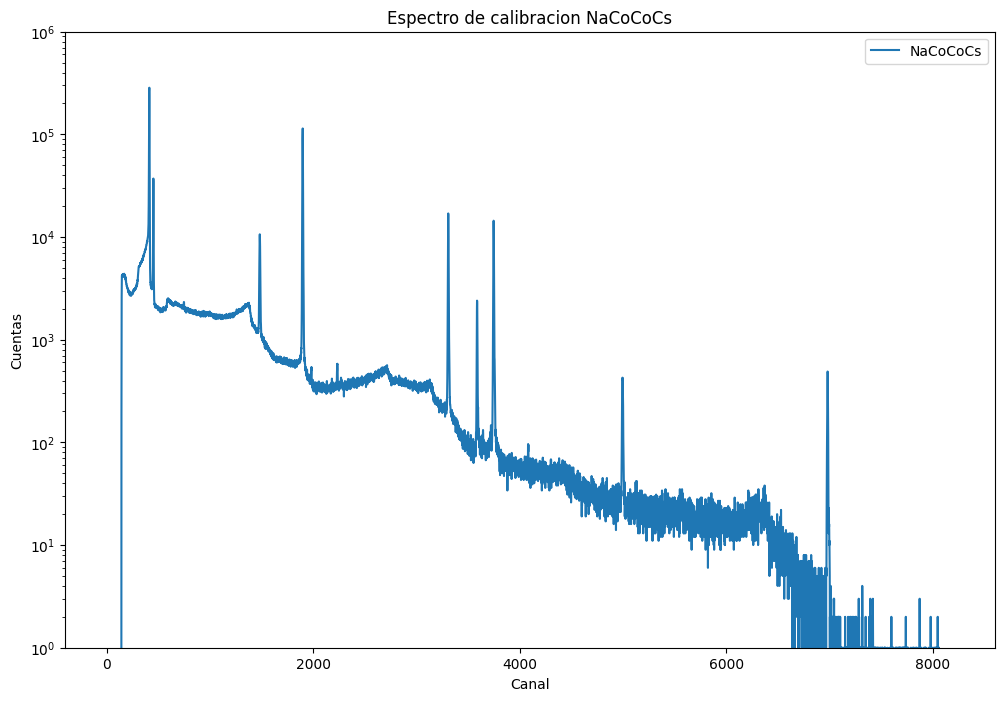

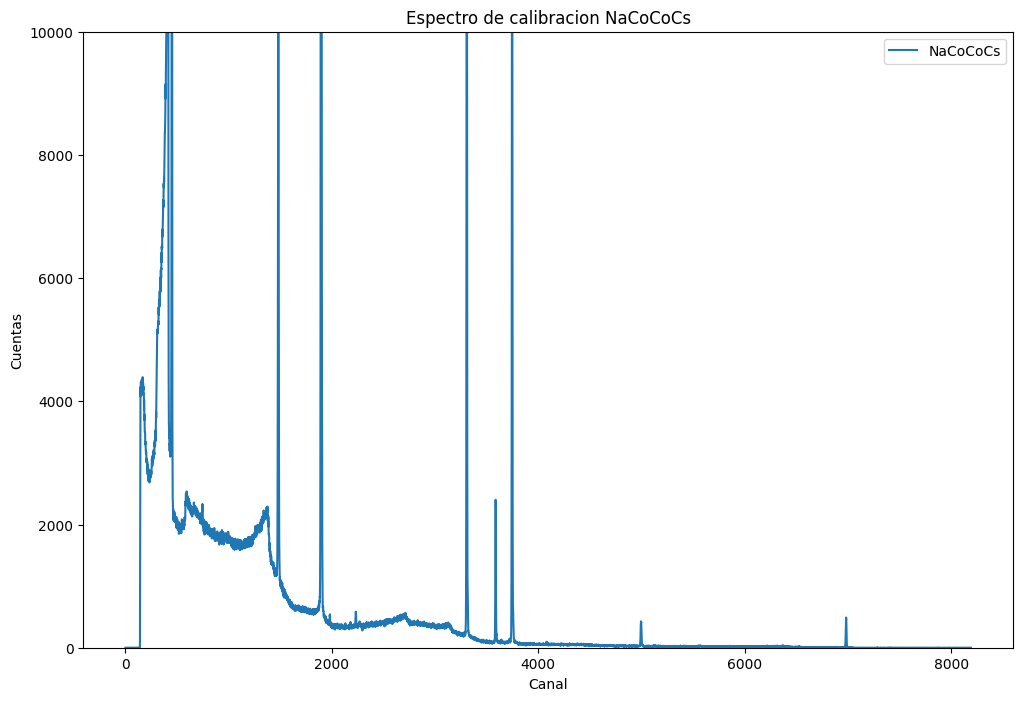

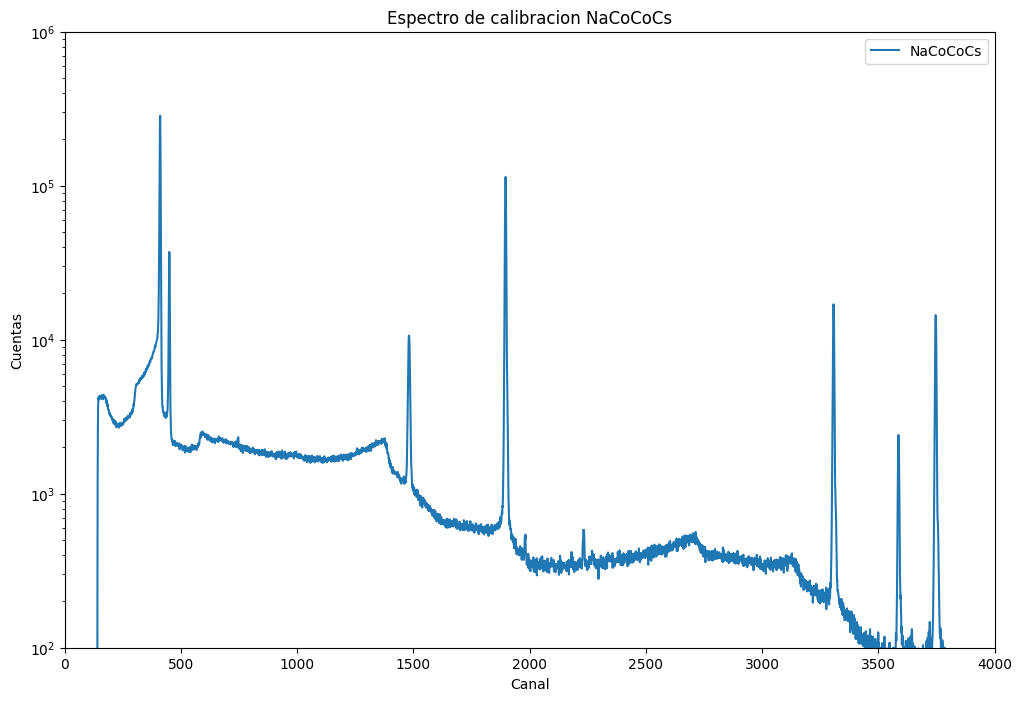

In [313]:
# Grafica de los datos NaCoCo. Eje y en escala logaritmica

plt.figure(figsize=(12, 8))
plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs')
plt.yscale('log')
plt.ylim(1, 1e6)
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs')
plt.ylim(0,10e3)
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs')
plt.yscale('log')
plt.ylim(1e2, 1e6)
plt.xlim(0, 4000)
plt.legend()
plt.show()

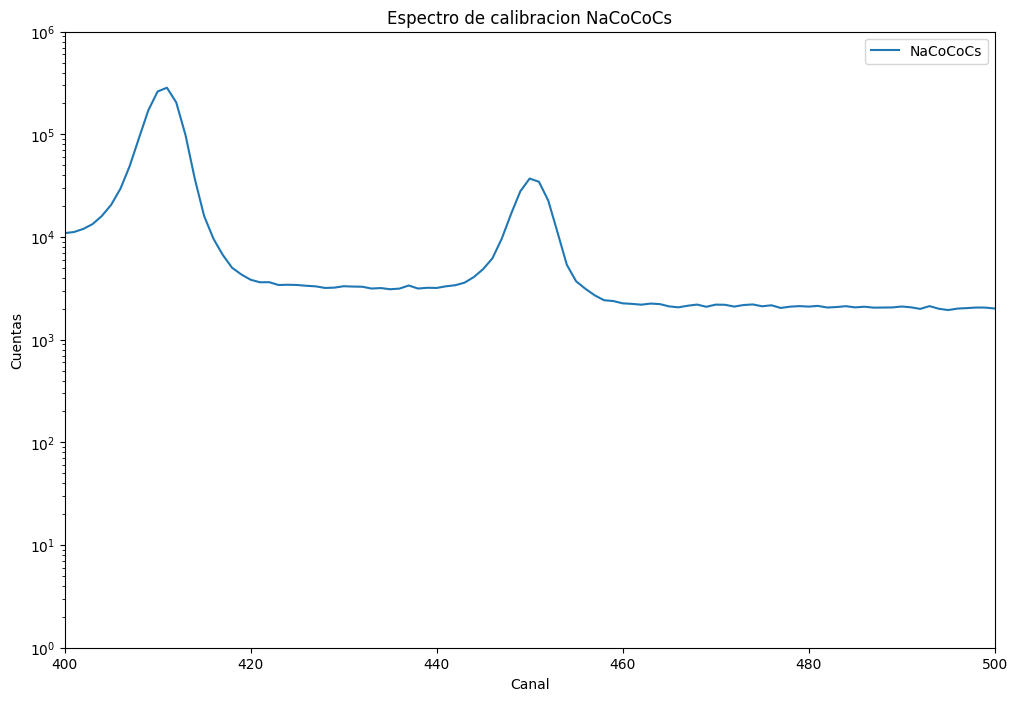

In [314]:

plt.figure(figsize=(12, 8))
plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs')
plt.ylim(1, 1e6)
plt.yscale('log')
plt.xlim(400,500)
plt.legend()
plt.show()

Considerando los elementos los picos esperados 

In [315]:
# create a dictionary with the values and their corresponding names
values = {'22Na_1': 1274.537,
          '60Co_1': 1173.228,
          '60Co_2': 1332.490,
          '137Cs_1': 661.657,
          '137Cs_alfa': 32.06,
          '137Cs_beta': 36.66,
          '57Co_1': 122.06065,
          '57Co_2': 136.47350,
          'electron': 511,
          '60Co_3': 2505.748}

# sort the dictionary by its keys
p_energia = sorted(values.items(), key=lambda x: x[1])

# create a new list with values except '137Cs_alfa' and '137Cs_beta'
p_energia_adj = [(key, value) for key, value in p_energia if key not in ['137Cs_alfa', '137Cs_beta']]

2. Asignación de los picos de energía

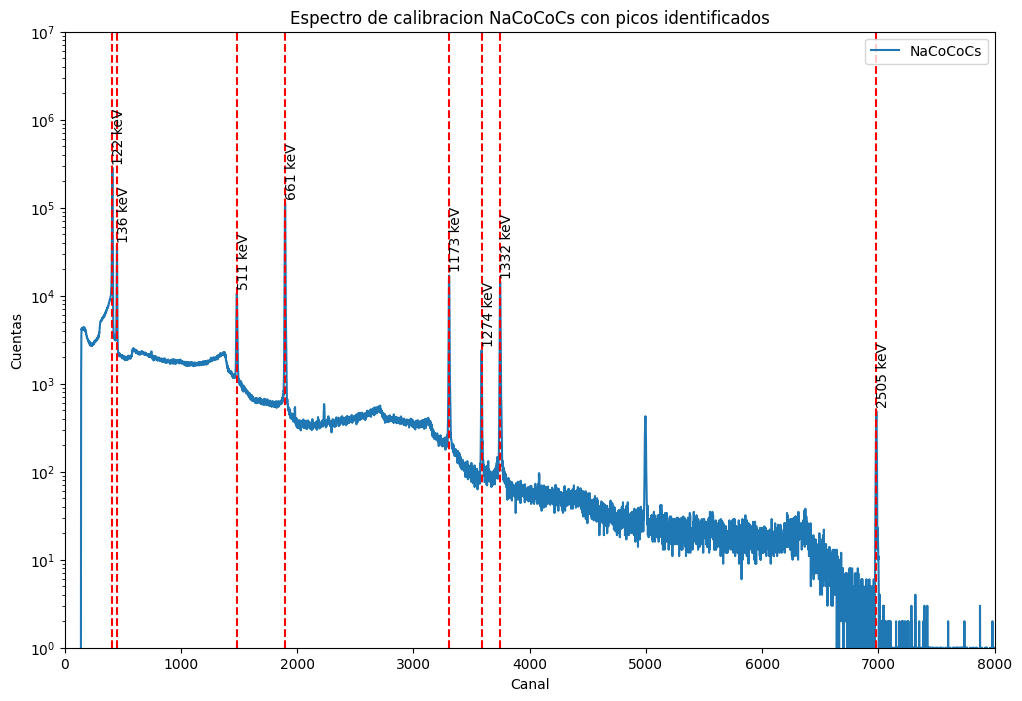

In [316]:
# Se estima que los picos están en los canales:

p_canal_estimado = [410, 450, 1490, 1900, 3300, 3590, 3750, 7000]

# Se busca el valor p_canal maximo real a partir del valor p_canal_estimado

p_canal = []

for i in range(len(p_energia_adj)):
    p_canal.append(np.argmax(NaCoCo[p_canal_estimado[i]-30:p_canal_estimado[i]+30,1])+p_canal_estimado[i]-30)

# plot the spectrum of NaCoCo

plt.figure(figsize=(12, 8))
plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs con picos identificados')
plt.yscale('log')
plt.ylim(1, 1e7)
plt.legend()

# add vertical lines and text for energy peaks (-1 es para no imprimir el ultimo pico)
for i in range(len(p_canal)):
    plt.axvline(x=p_canal[i], color='r', linestyle='--')
    plt.text(p_canal[i], 1.1*NaCoCo[p_canal[i],1], str(int(p_energia_adj[i][1]))+' keV', va='bottom',rotation=90)
plt.xlim(0, 8000)
plt.show()

## Calibración

1. Ajuste NaCoCoCs

In [317]:
e_canal = [(p_energia_adj[i][0],p_energia_adj[i][1], p_canal[i]) for i in range(len(p_canal))]

# eliminar los valores de e_canal para 57Co_2 y electron

e_canal_cal = [(key, value, canal) for key, value, canal in e_canal if key not in ['57Co_2', 'electron', '60Co_1']]


# Ajuste de gaussiana al rededor de cada fotopico de e_canal_cal

from scipy.optimize import curve_fit

def gaussiana_lineal(x, a, x0, sigma, b_0, b_1):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b_0 + b_1*x

def gaussiana(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
# Se define un rango de ajuste para cada fotopico

rango_ajuste = [(canal-30, canal+30) for key, value, canal in e_canal_cal]

# Se define un rango de ajuste para cada fotopico
# los parametros optimos son guardados en popt y la covarianza en pcov
# popt_i = [a, x0, sigma] para el i-esimo fotopico
# pcov_i = matriz de covarianza para el i-esimo fotopico
# a = amplitud, x0 = centro, sigma = desviacion estandar

popt = []
pcov = []

for i in range(len(rango_ajuste)):
    popt_i, pcov_i = curve_fit(gaussiana_lineal, NaCoCo[rango_ajuste[i][0]:rango_ajuste[i][1],0], NaCoCo[rango_ajuste[i][0]:rango_ajuste[i][1],1], p0=[NaCoCo[e_canal_cal[i][2],1], e_canal_cal[i][2], 10, 0, 0], bounds=([-np.inf, -np.inf, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf]))
    popt.append(popt_i)
    pcov.append(pcov_i)
incertidumbres = np.sqrt(np.diagonal(pcov, axis1=1, axis2=2))


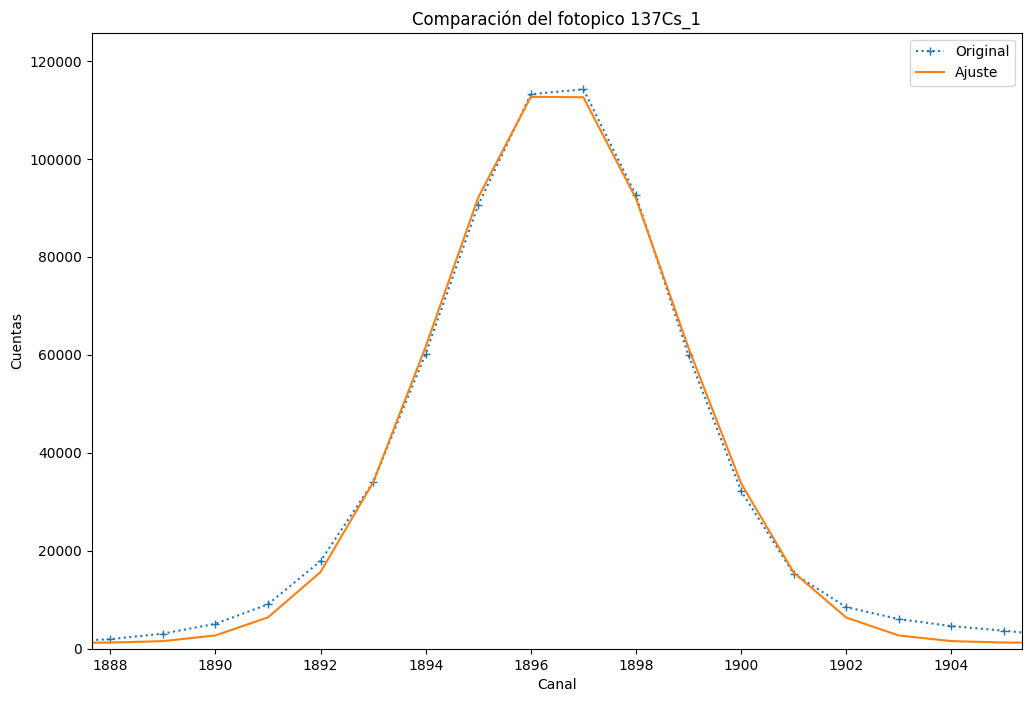

In [318]:
# calculate the adjusted values of the counts for each channel
ajuste = [gaussiana_lineal(NaCoCo[:,0], *popt_i) for popt_i in popt]
ajuste_sin_fondo = [gaussiana(NaCoCo[:,0], *popt_i[0:3]) for popt_i in popt]
# plot the first gaussian linear along with the original values to compare and limit the width to 4 sigma
graph_i = 1

plt.figure(figsize=(12, 8))
plt.plot(NaCoCo[:,0], NaCoCo[:,1], '+:', label='Original')
plt.plot(NaCoCo[:,0], ajuste[graph_i], label='Ajuste')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title(f'Comparación del fotopico {e_canal_cal[graph_i][0]}')
plt.xlim(popt[graph_i][1]-4*popt[graph_i][2], popt[graph_i][1]+4*popt[graph_i][2])
plt.ylim(0, 1.1*popt[graph_i][0])
plt.legend()
plt.show()


In [319]:
from scipy.integrate import quad

intensidades = []
incertidumbres_int = []

def integ_riemman(x,y):
    integral = 0
    dx = x[1]-x[0]
    for i in range(len(x)):
        integral = integral + dx*y[i]
    return integral

sigmas = 3
rango_integracion = [(int(popt[i][1]-sigmas*popt[i][2]), int(popt[i][1]+sigmas*popt[i][2])) for i in range(len(popt))]
print("Ajustes con fondo")
for i in range(len(popt)):
    integral = integ_riemman(NaCoCo[rango_integracion[i][0]:rango_integracion[i][1],0], ajuste[i][rango_integracion[i][0]:rango_integracion[i][1]])
    intensidades.append(integral)
    incertidumbres_int.append(incertidumbres[i][0]*integral/popt[i][0])

for i in range(len(intensidades)):
    print(f'Intensidad del pico {e_canal_cal[i][0]}: {intensidades[i]:.2f} +/- {incertidumbres_int[i]:.2f}')

print("Ajustes sin fondo")

intensidades_sin_fondo = []
incertidumbres_int_sin_fondo = []

for i in range(len(popt)):
    integral = integ_riemman(NaCoCo[rango_integracion[i][0]:rango_integracion[i][1],0], ajuste_sin_fondo[i][rango_integracion[i][0]:rango_integracion[i][1]])
    intensidades_sin_fondo.append(integral)
    incertidumbres_int_sin_fondo.append(incertidumbres[i][0]*integral/popt[i][0])

for i in range(len(intensidades_sin_fondo)):
    print(f'Intensidad del pico {e_canal_cal[i][0]}: {intensidades_sin_fondo[i]:.2f} +/- {incertidumbres_int_sin_fondo[i]:.2f}')

Ajustes con fondo
Intensidad del pico 57Co_1: 1219978.54 +/- 14160.25
Intensidad del pico 137Cs_1: 648224.82 +/- 4214.38
Intensidad del pico 22Na_1: 16784.23 +/- 147.83
Intensidad del pico 60Co_2: 97206.58 +/- 567.05
Intensidad del pico 60Co_3: 4010.35 +/- 45.24
Ajustes sin fondo
Intensidad del pico 57Co_1: 1144307.86 +/- 13281.94
Intensidad del pico 137Cs_1: 631595.06 +/- 4106.27
Intensidad del pico 22Na_1: 15027.85 +/- 132.36
Intensidad del pico 60Co_2: 94078.18 +/- 548.80
Intensidad del pico 60Co_3: 3876.79 +/- 43.73


In [320]:
import pandas as pd

# create a dictionary with the values we want to include in the table
data = {
    'E_gamma (keV)': [f"{round(value, 1)}" for i, (key, value, canal) in enumerate(e_canal_cal)],
    'canal': [f"{round(popt_i[1], 2)} ({int(incertidumbres[i][1]*100+1)})" for i, popt_i in enumerate(popt)],
    'sigma (canales)': [f"{round(popt_i[2], 2)} ({int(incertidumbres[i][2]*100+1)})" for i, popt_i in enumerate(popt)],
    'I_gamma (cuentas)': [f"{int(intensidades_sin_fondo[i])} ({int(incertidumbres[i][3]+1)})" for i in range(len(intensidades_sin_fondo))]
}
# create a new dataframe with the dictionary
df_1 = pd.DataFrame(data)

# print the dataframe
print(df_1)

  E_gamma (keV)        canal sigma (canales) I_gamma (cuentas)
0         122.1   410.61 (3)        1.67 (3)   1144307 (13670)
1         661.7   1896.5 (2)        2.21 (2)    631595 (16797)
2        1274.5  3586.65 (3)        2.57 (3)       15027 (949)
3        1332.5  3746.46 (2)        2.62 (2)      94078 (4069)
4        2505.7  6982.47 (5)        3.28 (5)        3876 (539)


2. Ajuste Eu

In [321]:
import numpy as np

# crear una lista con los valores de E_gamma, canal y sigma
e_canal_cal_np = np.array([(value, popt[i][1], popt[i][2]) for i, (key, value, canal) in enumerate(e_canal_cal)], dtype=[('E_gamma_valor', float), ('canal', float), ('sigma', float)])

# calcular las intensidades
intensidades_np = np.array(intensidades_sin_fondo, dtype=float)

# combinar todas las listas en una tabla numpy
# crear un DataFrame con los valores de E_gamma, canal y sigma
df_1n = pd.DataFrame(e_canal_cal_np)

# agregar la columna de intensidades al DataFrame
df_1n['intensidades'] = intensidades_np


print(df_1n)


   E_gamma_valor        canal     sigma  intensidades
0      122.06065   410.608637  1.667297  1.144308e+06
1      661.65700  1896.496083  2.211073  6.315951e+05
2     1274.53700  3586.654259  2.574005  1.502785e+04
3     1332.49000  3746.461935  2.621041  9.407818e+04
4     2505.74800  6982.467618  3.276904  3.876787e+03


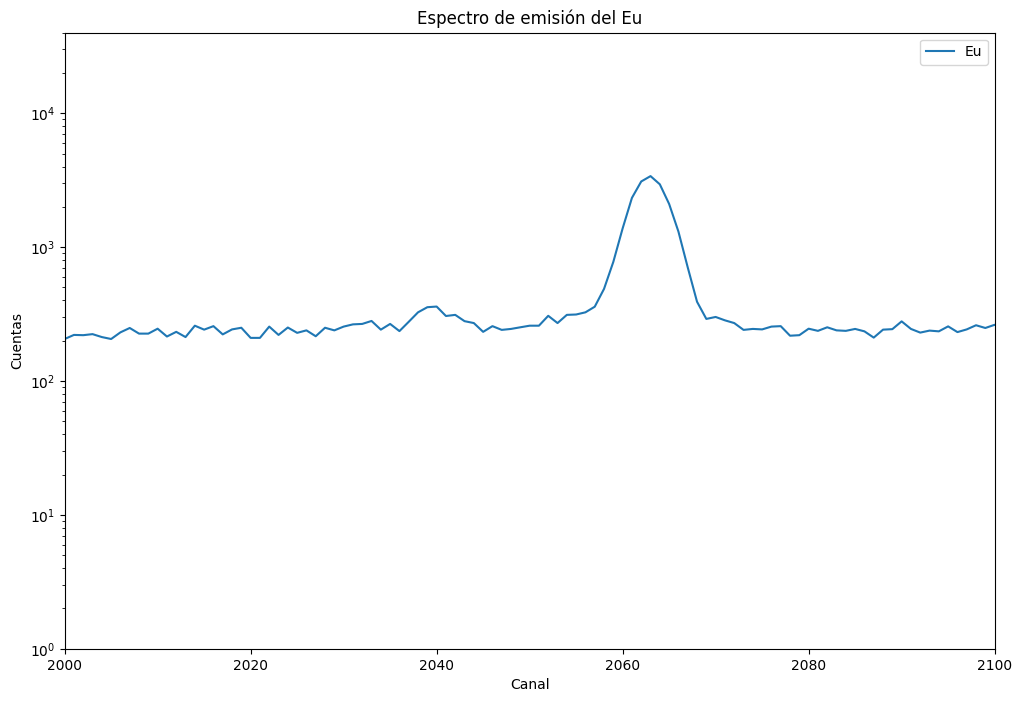

In [322]:
# Grafica de los datos Eu, Eje y en escala logaritmica

plt.figure(figsize=(12, 8))
plt.plot(Eu[:,0], Eu[:,1], label='Eu')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de emisión del Eu')
plt.ylim(1, 4e4)
plt.yscale('log')
plt.xlim(2000, 2100)
plt.legend()
plt.show()


In [323]:
p_energia_adj_Eu = [('p_1', 86.5),('p_2', 105.3),('p_3', 344.3),( 'p_4', 732.3),('p_5', 964.1),('p_6', 1274.5),('p_7', 1596.5)]

p_canal_est_Eu = [310, 360, 1020, 2060, 2725, 3580, 4480]

# Se busca el valor p_canal maximo real a partir del valor p_canal_estimado

p_canal_Eu = []

for i in range(len(p_energia_adj_Eu)):
    p_canal_Eu.append(np.argmax(Eu[p_canal_est_Eu[i]-30:p_canal_est_Eu[i]+30,1])+p_canal_est_Eu[i]-30)

In [324]:

e_canal_Eu = [(p_energia_adj_Eu[i][0],p_energia_adj_Eu[i][1], p_canal_Eu[i]) for i in range(len(p_canal_Eu))]

# eliminar los valores de e_canal para 57Co_2 y electron

#e_canal_cal_Eu = [(key, value, canal) for key, value, canal in e_canal_Eu if key not in ['57Co_2', 'electron', '60Co_1']]
e_canal_cal_Eu = e_canal_Eu


# Ajuste de gaussiana al rededor de cada fotopico de e_canal_cal

# Se define un rango de ajuste para cada fotopico

rango_ajuste = [(canal-30, canal+30) for key, value, canal in e_canal_cal_Eu]

# Se define un rango de ajuste para cada fotopico
# los parametros optimos son guardados en popt y la covarianza en pcov
# popt_i = [a, x0, sigma] para el i-esimo fotopico
# pcov_i = matriz de covarianza para el i-esimo fotopico
# a = amplitud, x0 = centro, sigma = desviacion estandar

popt_Eu = []
pcov_Eu = []

for i in range(len(rango_ajuste)):
    popt_i, pcov_i = curve_fit(gaussiana_lineal, Eu[rango_ajuste[i][0]:rango_ajuste[i][1],0], Eu[rango_ajuste[i][0]:rango_ajuste[i][1],1], p0=[Eu[e_canal_cal_Eu[i][2],1], e_canal_cal_Eu[i][2], 10, 0, 0], bounds=([-np.inf, -np.inf, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf]))
    popt_Eu.append(popt_i)
    pcov_Eu.append(pcov_i)
incertidumbres_Eu = np.sqrt(np.diagonal(pcov_Eu, axis1=1, axis2=2))

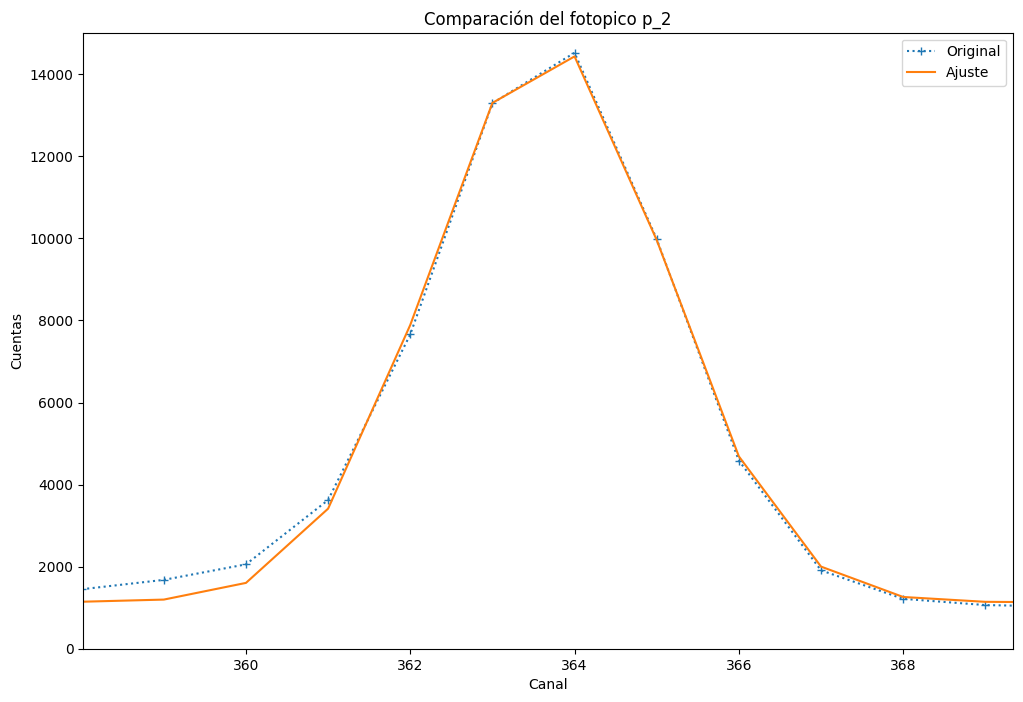

In [325]:
# calculate the adjusted values of the counts for each channel
adj_Eu = [gaussiana_lineal(Eu[:,0], *popt_i) for popt_i in popt_Eu]
adj_Eu_sin_fondo = [gaussiana(Eu[:,0], *popt_i[0:3]) for popt_i in popt_Eu]
# plot the first gaussian linear along with the original values to compare and limit the width to 4 sigma
graph_i = 1

plt.figure(figsize=(12, 8))
plt.plot(Eu[:,0], Eu[:,1], '+:', label='Original')
plt.plot(Eu[:,0], adj_Eu[graph_i], label='Ajuste')

plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title(f'Comparación del fotopico {e_canal_cal_Eu[graph_i][0]}')
plt.xlim(popt_Eu[graph_i][1]-4*popt_Eu[graph_i][2], popt_Eu[graph_i][1]+4*popt_Eu[graph_i][2])
plt.ylim(0, 1.1*popt_Eu[graph_i][0])
plt.legend()
plt.show()

In [326]:


intensidades_Eu = []
incertidumbres_int_Eu = []

sigmas = 3
rango_integracion_Eu = [(int(popt_Eu[i][1]-sigmas*popt_Eu[i][2]), int(popt_Eu[i][1]+sigmas*popt_Eu[i][2])) for i in range(len(popt_Eu))]
print("Ajustes con fondo")
for i in range(len(popt_Eu)):
    integral = integ_riemman(Eu[rango_integracion_Eu[i][0]:rango_integracion_Eu[i][1],0], adj_Eu[i][rango_integracion_Eu[i][0]:rango_integracion_Eu[i][1]])
    intensidades_Eu.append(integral)
    incertidumbres_int_Eu.append(incertidumbres_Eu[i][0]*integral/popt_Eu[i][0])

for i in range(len(intensidades_Eu)):
    print(f'Intensidad del pico {e_canal_cal_Eu[i][0]}: {intensidades_Eu[i]:.2f} +/- {incertidumbres_int_Eu[i]:.2f}')

print("Ajustes sin fondo")

intensidades_sin_fondo_Eu = []
incertidumbres_int_sin_fondo_Eu = []

for i in range(len(popt_Eu)):
    integral = integ_riemman(Eu[rango_integracion_Eu[i][0]:rango_integracion_Eu[i][1],0], adj_Eu_sin_fondo[i][rango_integracion_Eu[i][0]:rango_integracion_Eu[i][1]])
    intensidades_sin_fondo_Eu.append(integral)
    incertidumbres_int_sin_fondo_Eu.append(incertidumbres_Eu[i][0]*integral/popt_Eu[i][0])

for i in range(len(intensidades_sin_fondo_Eu)):
    print(f'Intensidad del pico {e_canal_cal_Eu[i][0]}: {intensidades_sin_fondo_Eu[i]:.2f} +/- {incertidumbres_int_sin_fondo_Eu[i]:.2f}')


Ajustes con fondo
Intensidad del pico p_1: 66426.94 +/- 625.34
Intensidad del pico p_2: 56489.26 +/- 399.43
Intensidad del pico p_3: 64414.19 +/- 240.81
Intensidad del pico p_4: 19528.21 +/- 119.83
Intensidad del pico p_5: 15939.01 +/- 97.95
Intensidad del pico p_6: 22316.58 +/- 87.90
Intensidad del pico p_7: 1803.64 +/- 14.03
Ajustes sin fondo
Intensidad del pico p_1: 57359.03 +/- 539.98
Intensidad del pico p_2: 47395.38 +/- 335.13
Intensidad del pico p_3: 60408.73 +/- 225.83
Intensidad del pico p_4: 16073.32 +/- 98.63
Intensidad del pico p_5: 13882.07 +/- 85.31
Intensidad del pico p_6: 21513.53 +/- 84.73
Intensidad del pico p_7: 1746.18 +/- 13.58


In [327]:

# create a dictionary with the values we want to include in the table
data2 = {
    'E_gamma (keV)': [f"{round(value, 1)}" for i, (key, value, canal) in enumerate(e_canal_cal_Eu)],
    'canal': [f"{round(popt_i[1], 2)} ({int(incertidumbres_Eu[i][1]*100)+1})" for i, popt_i in enumerate(popt_Eu)],
    'sigma (canales)': [f"{round(popt_i[2], 2)} ({int(incertidumbres_Eu[i][2]*100+1)})" for i, popt_i in enumerate(popt_Eu)],
    'I_gamma (cuentas)': [f"{int(intensidades_sin_fondo_Eu[i])} ({int(incertidumbres_Eu[i][3]+1)})" for i in range(len(intensidades_sin_fondo_Eu))]
}
# create a new dataframe with the dictionary
df_2 = pd.DataFrame(data2)

# print the dataframe
print(df_2)

  E_gamma (keV)        canal sigma (canales) I_gamma (cuentas)
0          86.5   312.15 (2)        1.37 (2)       57359 (465)
1         105.3   363.68 (2)        1.42 (2)       47395 (337)
2         344.3   1020.1 (1)        1.75 (1)       60408 (561)
3         732.3   2062.9 (2)        2.06 (2)       16073 (455)
4         964.1  2725.83 (2)        2.27 (2)       13882 (497)
5        1274.5  3580.56 (2)        2.47 (2)       21513 (623)
6        1596.5  4467.27 (3)        2.71 (3)        1746 (119)


In [328]:
# crear una lista con los valores de E_gamma, canal y sigma
e_canal_cal_np = np.array([(value, popt_Eu[i][1], popt_Eu[i][2]) for i, (key, value, canal) in enumerate(e_canal_cal_Eu)], dtype=[('E_gamma_valor', float), ('canal', float), ('sigma', float)])

# calcular las intensidades
intensidades_np = np.array(intensidades_sin_fondo_Eu, dtype=float)

# combinar todas las listas en una tabla numpy
# crear un DataFrame con los valores de E_gamma, canal y sigma
df_2n = pd.DataFrame(e_canal_cal_np)

# agregar la columna de intensidades al DataFrame
df_2n['intensidades'] = intensidades_np


print(df_2n)

   E_gamma_valor        canal     sigma  intensidades
0           86.5   312.154534  1.374403  57359.027843
1          105.3   363.678500  1.415118  47395.384200
2          344.3  1020.100330  1.752674  60408.729085
3          732.3  2062.902476  2.064680  16073.322562
4          964.1  2725.834874  2.273026  13882.073659
5         1274.5  3580.557063  2.465363  21513.534477
6         1596.5  4467.269190  2.707967   1746.177117


3. Graficas y ajustes de calibración

    3.a E_gamma vs E canal

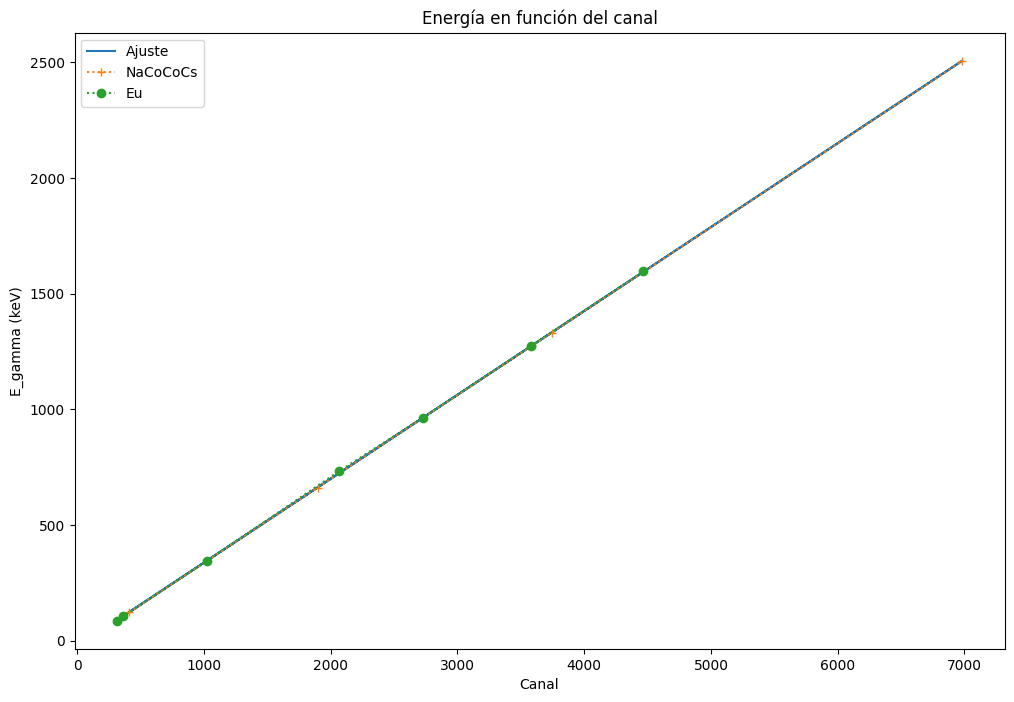

        a_1           a_0
0  0.36 (1)  -25.06 (156)


In [329]:
# E_gamma vs canal
# ajuste lineal
# E_gamma = a*canal + b

from scipy.stats import linregress

df_combined = pd.concat([df_1n, df_2n])
a_1, a_0, r_value, p_value, std_err = linregress(df_combined['canal'], df_combined['E_gamma_valor'])

# Los errores de la pendiente y la ordenada al origen son:

incert_a_1 = std_err
incert_a_0 = std_err*np.sqrt(np.mean(df_combined['canal']**2))

# plot the adjusted values of the counts for each channel
plt.figure(figsize=(12, 8))
plt.plot(df_combined['canal'], a_1*df_combined['canal']+a_0, label='Ajuste')
plt.plot(df_1n['canal'], df_1n['E_gamma_valor'], '+:', label='NaCoCoCs')
plt.plot(df_2n['canal'], df_2n['E_gamma_valor'], 'o:', label='Eu')
plt.xlabel('Canal')
plt.ylabel('E_gamma (keV)')
plt.title('Energía en función del canal')
plt.legend()
plt.show()


data3 = {
    'a_1': [f"{round(a_1, 2)} ({int(incert_a_1*100)+1})"],
    'a_0': [f"{round(a_0, 2)} ({int(incert_a_0*100)+1})"]
}

df_3 = pd.DataFrame(data3)

print(df_3)

    3.b FWHM

In [332]:
def fwhm(x, y):
    half_max = max(y) / 2.
    # find when function crosses line half_max (when sign of diff flips)
    # take the 'derivative' of signum(half_max - y[])
    d = np.sign(half_max - np.array(y[0:-1])) - np.sign(half_max - np.array(y[1:]))
    # find the left and right most indexes
    left_idx = np.where(d > 0)[0][0]
    right_idx = np.where(d < 0)[0][0]
    return abs(x[right_idx] - x[left_idx])

fwhm_NaCoCo = []
incert_fwhm_NaCoCo = []

for i in range(len(popt)):
    fwhm_NaCoCo.append(fwhm(NaCoCo[rango_integracion[i][0]:rango_integracion[i][1],0], ajuste[i][rango_integracion[i][0]:rango_integracion[i][1]]))
    incert_fwhm_NaCoCo.append(incertidumbres[i][2])

fwhm_Eu = []
incert_fwhm_Eu = []

for i in range(len(popt_Eu)):
    fwhm_Eu.append(fwhm(Eu[rango_integracion_Eu[i][0]:rango_integracion_Eu[i][1],0], adj_Eu[i][rango_integracion_Eu[i][0]:rango_integracion_Eu[i][1]]))
    incert_fwhm_Eu.append(incertidumbres_Eu[i][2])


In [333]:

data4 = {
    'fwhm (canales)': [f"{round(value, 2)} ({int(incert_fwhm_NaCoCo[i]*100)+1})" for i, value in enumerate(fwhm_NaCoCo)],
    'fwhm (keV)': [f"{round(value*a_1, 2)} ({int(incert_fwhm_NaCoCo[i]*100)+1})" for i, value in enumerate(fwhm_NaCoCo)]
}

df_4 = pd.DataFrame(data4)

print(df_4)

data5 = {
    'fwhm (canales)': [f"{round(value, 2)} ({int(incert_fwhm_Eu[i]*100)+1})" for i, value in enumerate(fwhm_Eu)],
    'fwhm (keV)': [f"{round(value*a_1, 2)} ({int(incert_fwhm_Eu[i]*100)+1})" for i, value in enumerate(fwhm_Eu)]
}

df_5 = pd.DataFrame(data5)

print(df_5)

  fwhm (canales) fwhm (keV)
0        4.0 (3)   1.45 (3)
1        6.0 (2)   2.18 (2)
2        6.0 (3)   2.18 (3)
3        6.0 (2)   2.18 (2)
4        8.0 (5)    2.9 (5)
  fwhm (canales) fwhm (keV)
0        3.0 (2)   1.09 (2)
1        4.0 (2)   1.45 (2)
2        5.0 (1)   1.81 (1)
3        5.0 (2)   1.81 (2)
4        5.0 (2)   1.81 (2)
5        6.0 (2)   2.18 (2)
6        6.0 (3)   2.18 (3)


f_0 = 2.78
f_1 = 0.09
l_0 = 3.82
l_1 = 0.00


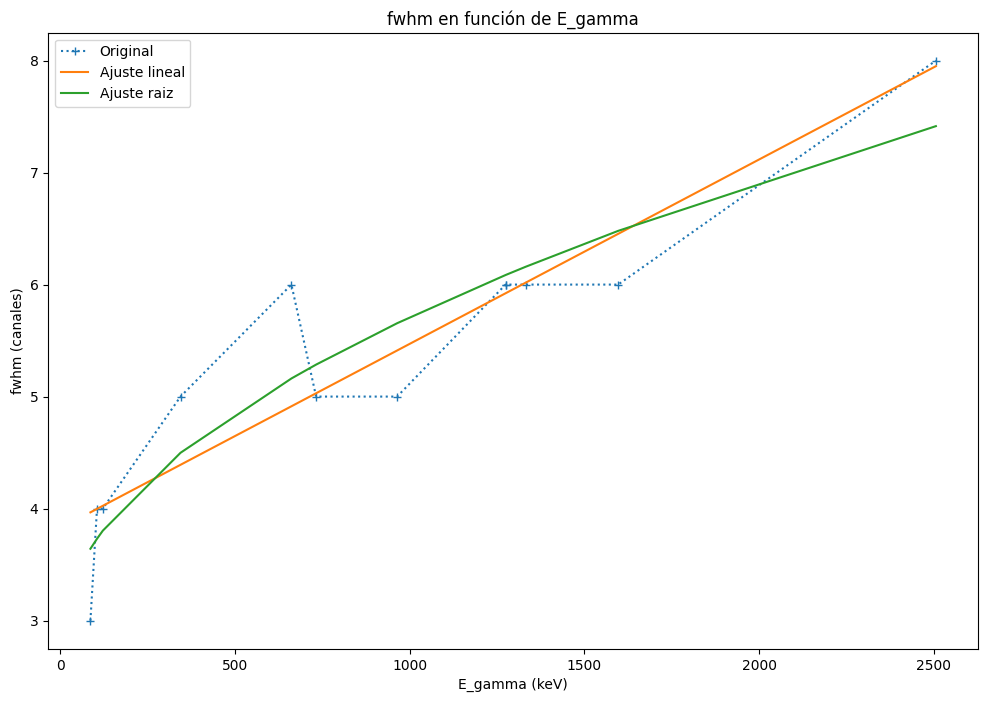

In [338]:
# define the function to fit
def fwhm_func_f(E_gamma, f_0, f_1):
    return f_0 + f_1 * np.sqrt(E_gamma)

# Concatenate the arrays
E_gamma = np.concatenate((df_1n['E_gamma_valor'], df_2n['E_gamma_valor']))
fwhm = np.concatenate((fwhm_NaCoCo, fwhm_Eu))

# Get the indices that would sort E_gamma
sort_indices = np.argsort(E_gamma)

# Use these indices to sort both E_gamma and fwhm
E_gamma_s = E_gamma[sort_indices]
fwhm_s = fwhm[sort_indices]

# perform the fit
popt_fwhm_f, pcov_fwhm_f = curve_fit(fwhm_func_f, E_gamma_s, fwhm_s)

# print the optimized parameters
print(f"f_0 = {popt_fwhm_f[0]:.2f}")
print(f"f_1 = {popt_fwhm_f[1]:.2f}")

def fwhm_func_l(E_gamma, l_0, l_1):
    return l_0 + l_1 * E_gamma

# perform the fit
popt_fwhm_l, pcov_fwhm_l = curve_fit(fwhm_func_l, E_gamma_s, fwhm_s)

# print the optimized parameters
print(f"l_0 = {popt_fwhm_l[0]:.2f}")
print(f"l_1 = {popt_fwhm_l[1]:.2f}")

# plot the adjusted values of the counts for each channel
plt.figure(figsize=(12, 8))
plt.plot(E_gamma_s, fwhm_s, '+:', label='Original')
plt.plot(E_gamma_s, fwhm_func_l(E_gamma_s, *popt_fwhm_l), label='Ajuste lineal')
plt.plot(E_gamma_s, fwhm_func_f(E_gamma_s, *popt_fwhm_f), label='Ajuste raiz')
plt.xlabel('E_gamma (keV)')
plt.ylabel('fwhm (canales)')
plt.title('fwhm en función de E_gamma')
plt.legend()
plt.show()


In [349]:
# measurement time in seconds Presumiendo que se midió durante 5 minutos
t = 600

# calculate the radioactive activity of Eu in Becquerel (Bq)
A_Eu = [A/t for A in intensidades_sin_fondo_Eu]

print(sum(A_Eu))

363.96374823707924
